# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [61]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Agora vamos importar as bases de dados

Para isso, vamos criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados a gente vai importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [10]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)

/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/1084043370.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/1084043370.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/1084043370.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/1084043370.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = bas

id                            listing_url       scrape_id  \
0         17878     https://www.airbnb.com/rooms/17878  20200121213543   
1         21280     https://www.airbnb.com/rooms/21280  20200121213543   
2         25026     https://www.airbnb.com/rooms/25026  20200121213543   
3         31560     https://www.airbnb.com/rooms/31560  20200121213543   
4         35636     https://www.airbnb.com/rooms/35636  20200121213543   
...         ...                                    ...             ...   
36373  33014188  https://www.airbnb.com/rooms/33014188  20190313042552   
36374  33014427  https://www.airbnb.com/rooms/33014427  20190313042552   
36375  33016673  https://www.airbnb.com/rooms/33016673  20190313042552   
36376  33021915  https://www.airbnb.com/rooms/33021915  20190313042552   
36377  33022085  https://www.airbnb.com/rooms/33022085  20190313042552   

      last_scraped                                               name  \
0       2020-01-22                  Very Nice 2Br - Copacabana - WiFi   
1       2020-01-22                   Renovated Modern Apt. Near Beach   
2       2020-01-22          Beautiful Modern Decorated Studio in Copa   
3       2020-01-22                   NICE & COZY 1BDR - IPANEMA BEACH   
4       2020-01-22                   Cosy flat close to Ipanema beach   
...            ...                                                ...   
36373   2019-03-13                Ótimo apartamento à 3 ruas da praia   
36374   2019-03-13          Maravilhoso Apto Com Vista Total Do Mar!!   
36375   2019-03-13            Próximo metrô largo do Machado e catete   
36376   2019-03-13  Aconchegante apt no posto 2, 100m praia, vista...   
36377   2019-03-13       Belíssimo conjugado no posto 2, a 100m praia   

                                                 summary  \
0      Pls note that special rates apply for Carnival...   
1      Immaculately renovated top-floor apartment ove...   
2      Our apartment is a little gem, everyone loves ...   
3      This nice and clean 1 bedroom apartment is loc...   
4      This cosy apartment  is just a few steps away ...   
...                                                  ...   
36373                                                NaN   
36374  Apartamento recém reformado, novinho e pronto ...   
36375                                                NaN   
36376                                                NaN   
36377                                                NaN   

                                                   space  \
0      - large balcony which looks out on pedestrian ...   
1      Immaculately renovated top-floor apartment in ...   
2      This newly renovated studio (last renovations ...   
3      This nice and clean 1 bedroom apartment is loc...   
4      The location is extremely convenient, safe and...   
...                                                  ...   
36373                                                NaN   
36374                                                NaN   
36375                                                NaN   
36376                                                NaN   
36377                                                NaN   

                                             description experiences_offered  \
0      Pls note that special rates apply for Carnival...                none   
1      Immaculately renovated top-floor apartment ove...                none   
2      Our apartment is a little gem, everyone loves ...                none   
3      This nice and clean 1 bedroom apartment is loc...                none   
4      This cosy apartment  is just a few steps away ...                none   
...                                                  ...                 ...   
36373  O bairro é simplesmente maravilhoso, a 5min a ...                none   
36374  Apartamento recém reformado, novinho e pronto ...                none   
36375  Próximo ao metrô largo do Machado e catete, me...                none   
36376

### Agora vamos começar os tratamentos

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [11]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:



In [12]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


host_response_time host_response_rate host_is_superhost  \
0          within an hour               100%                 t   
1          within an hour               100%                 f   
2            within a day                86%                 f   
3          within an hour               100%                 t   
4          within an hour               100%                 f   
...                   ...                ...               ...   
36373                 NaN                NaN                 f   
36374                 NaN                NaN                 f   
36375                 NaN                NaN                 f   
36376  within a few hours                84%                 f   
36377  within a few hours                84%                 f   

       host_listings_count  latitude  longitude property_type  \
0                      2.0 -22.96592  -43.17896   Condominium   
1                      0.0 -22.98467  -43.19611     Apartment   
2                      3.0 -22.97712  -43.19045     Apartment   
3                      1.0 -22.98302  -43.21427     Apartment   
4                      1.0 -22.98816  -43.19359     Apartment   
...                    ...       ...        ...           ...   
36373                  1.0 -23.02612  -43.46498   Condominium   
36374                  1.0 -23.01049  -43.36381     Apartment   
36375                  1.0 -22.92795  -43.17568     Apartment   
36376                 34.0 -22.96248  -43.17447     Apartment   
36377                 34.0 -22.96248  -43.17447     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             5        1.0  ...   
1      Entire home/apt             6        2.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             2        1.5  ...   
...                ...           ...        ...  ...   
36373  Entire home/apt             6        2.5  ...   
36374  Entire home/apt             6        1.0  ...   
36375  Entire home/apt             2        1.0  ...   
36376  Entire home/apt             5        1.0  ...   
36377  Entire home/apt             5        1.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                           10.0                   10.0   
1                           10.0                   10.0   
2                           10.0                    9.0   
3                           10.0                   10.0   
4                            9.0                   10.0   
...                          ...                    ...   
36373                        NaN                    NaN   
36374                        NaN                    NaN   
36375                        NaN                    NaN   
36376                        NaN                    NaN   
36377                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                            10.0                   10.0                 9.0   
1                            10.0                   10.0                10.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                10.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
36373                         NaN                    NaN                 NaN   
36374                         NaN                    NaN                 NaN   
36375                         NaN                    NaN                 NaN   
36376                         NaN                    NaN                 NaN   
36377                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  \
0         

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [13]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
display(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64

- Agora vamos excluir as linhas vazias

In [14]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [15]:
print(base_airbnb.dtypes)
print()
print('-'*77)
print()
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object

-----------------------------------------------------------------------------

host_is_superhost                                                           t


- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [16]:
# convertendo os valores da coluna Price de object para float
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# convertendo os valores da coluna Extra People de object para float
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)



/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2957249202.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2957249202.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2565596104.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(base_airbnb.corr(), annot=True, cmap='Reds')


<Axes: >

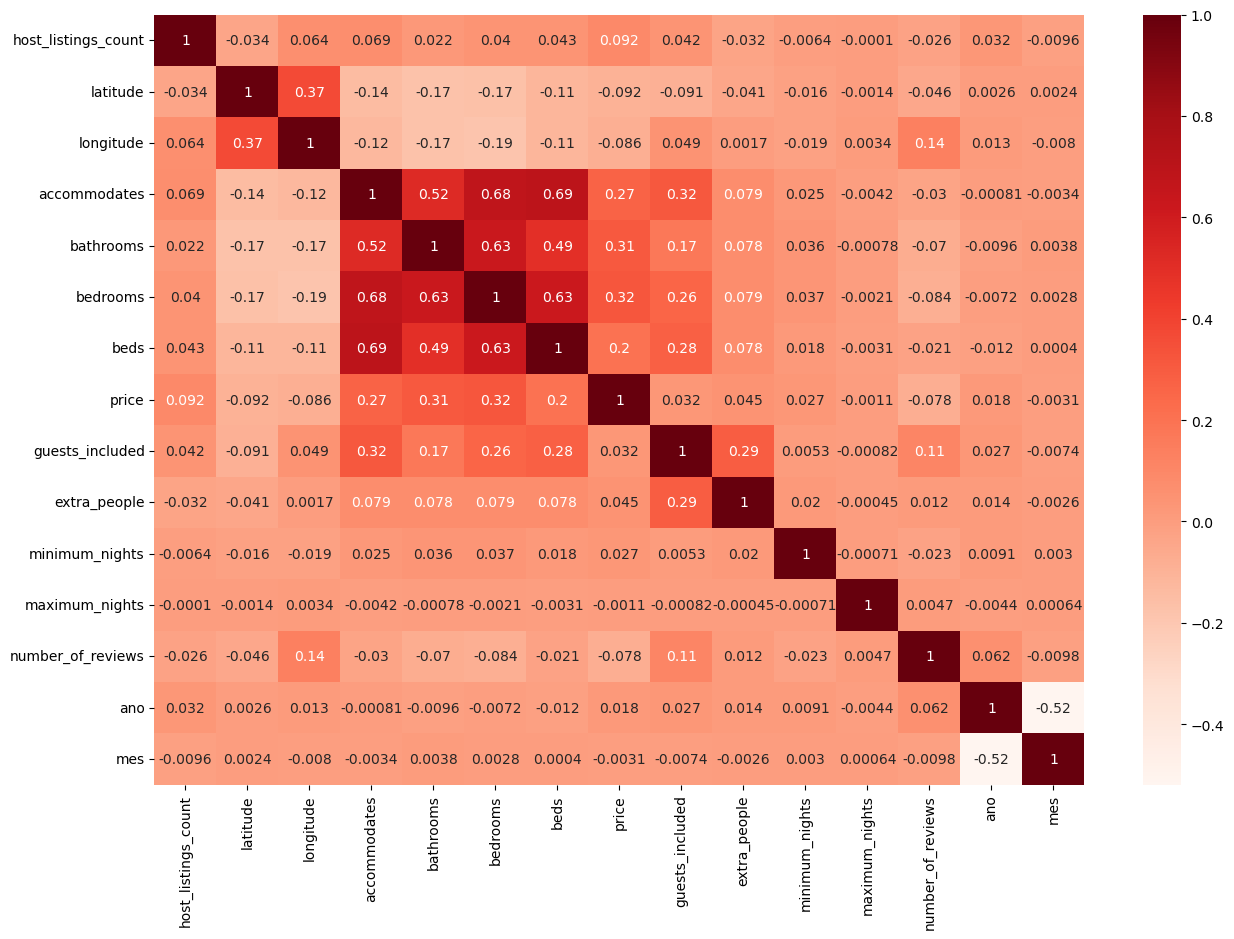

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Reds')


### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [18]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas


In [19]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax = ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax = ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist=True)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))
    

## price

/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2043756836.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


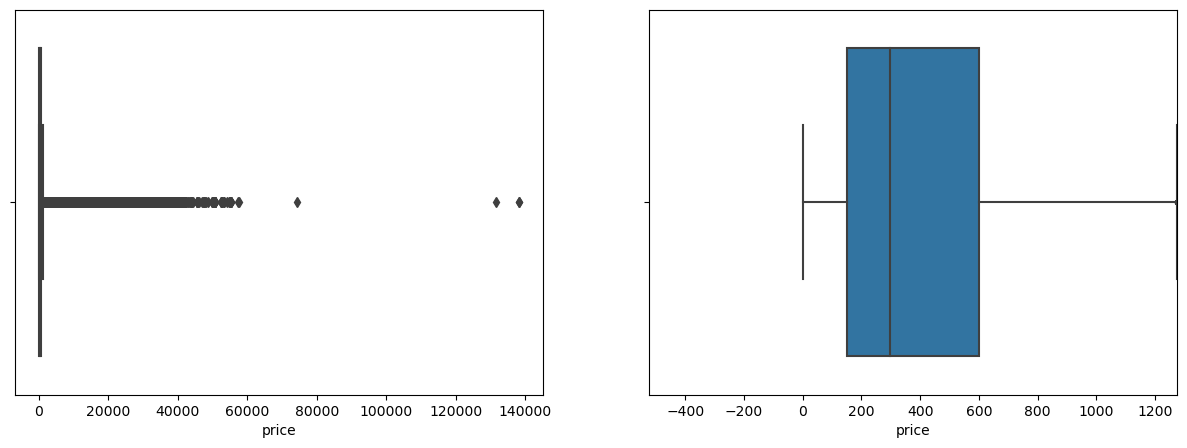

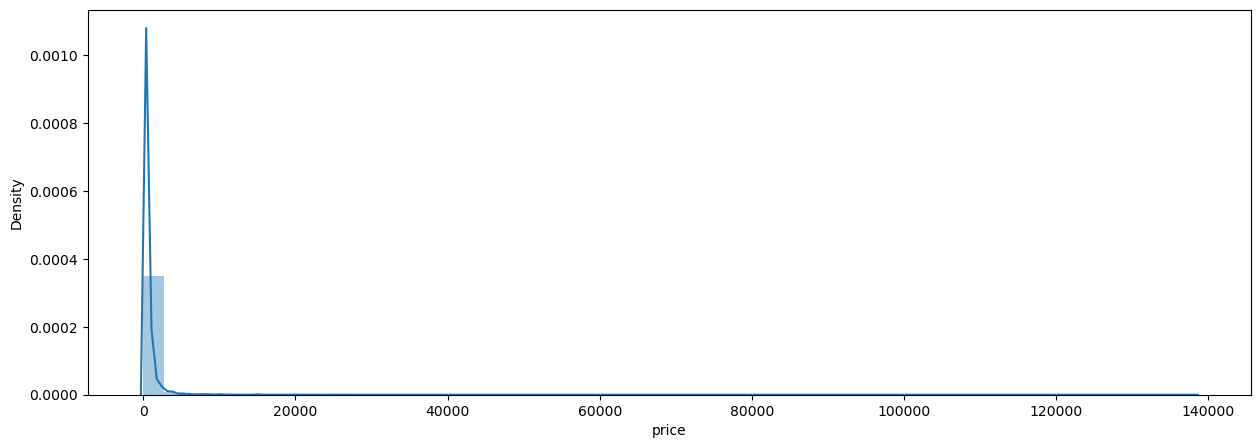

In [20]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas')

87282 linhas removidas


/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2043756836.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


(810427, 23)


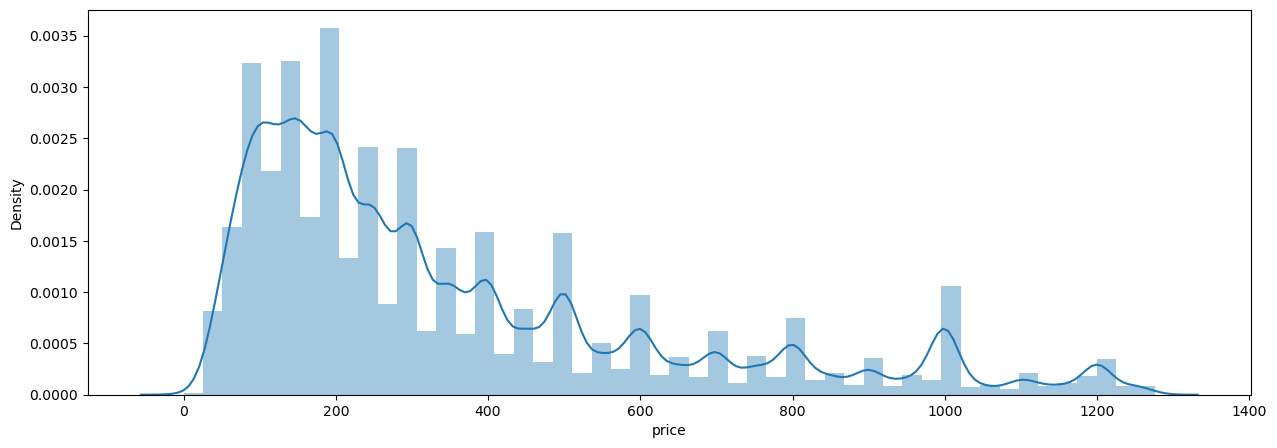

In [22]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra people

/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_18683/2043756836.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


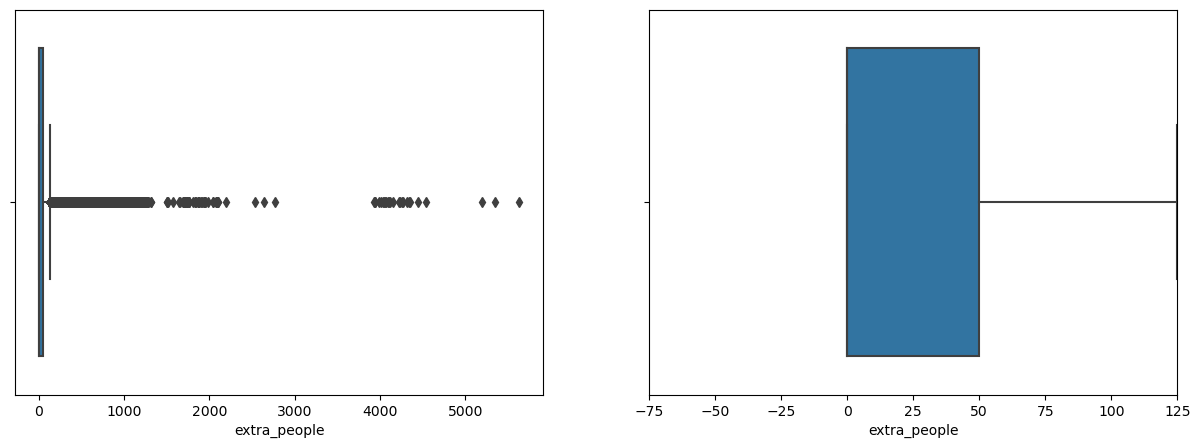

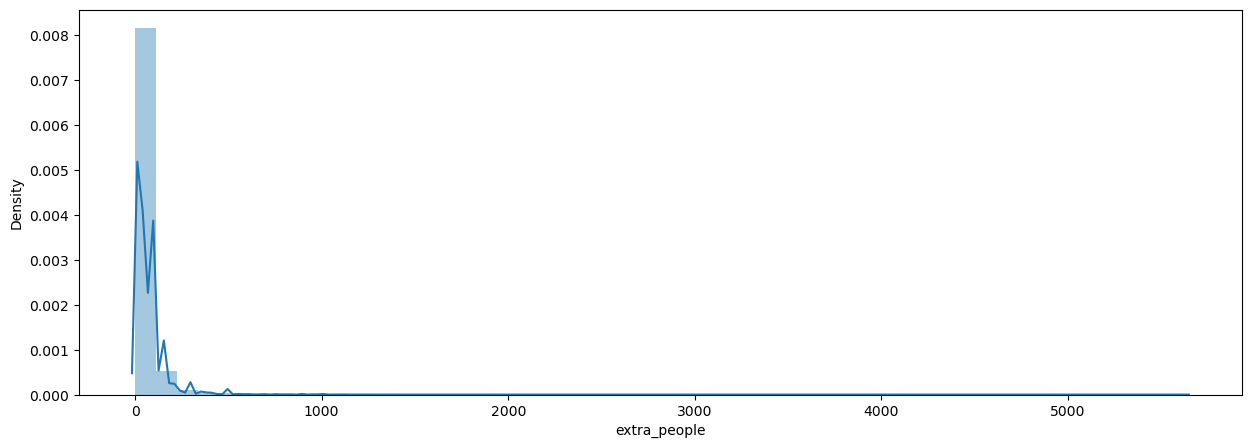

In [23]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas')

59194 linhas removidas


### host_listings_count

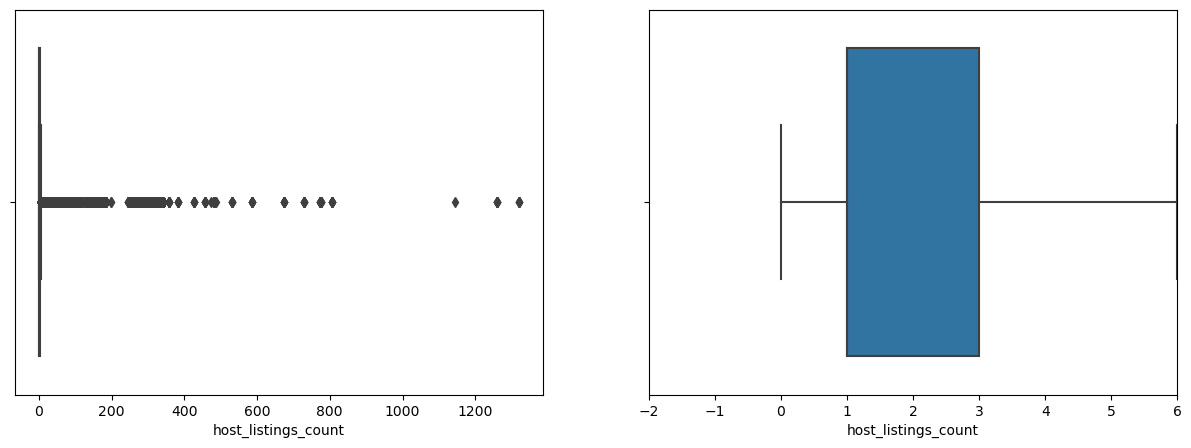

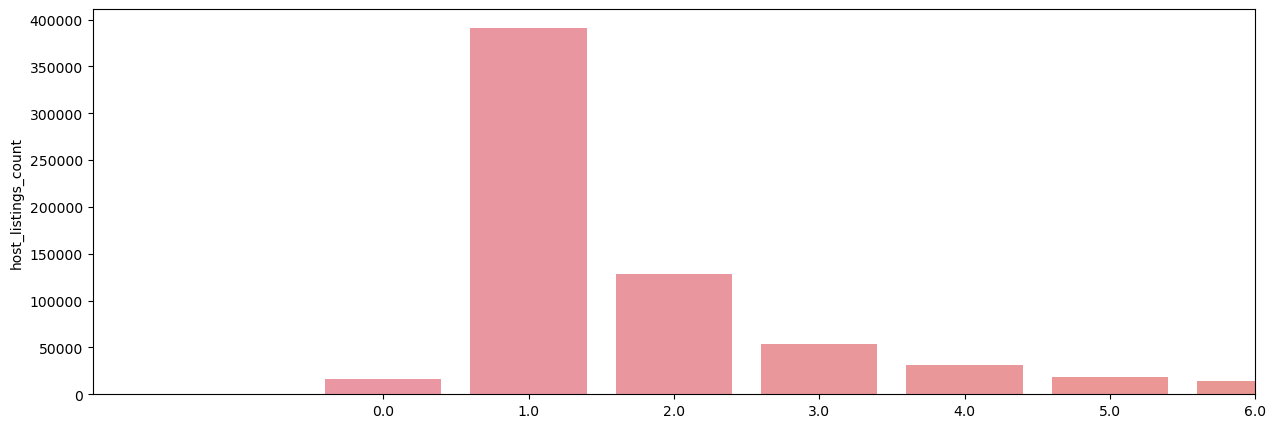

In [25]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas')

97723 linhas removidas


### accommodates

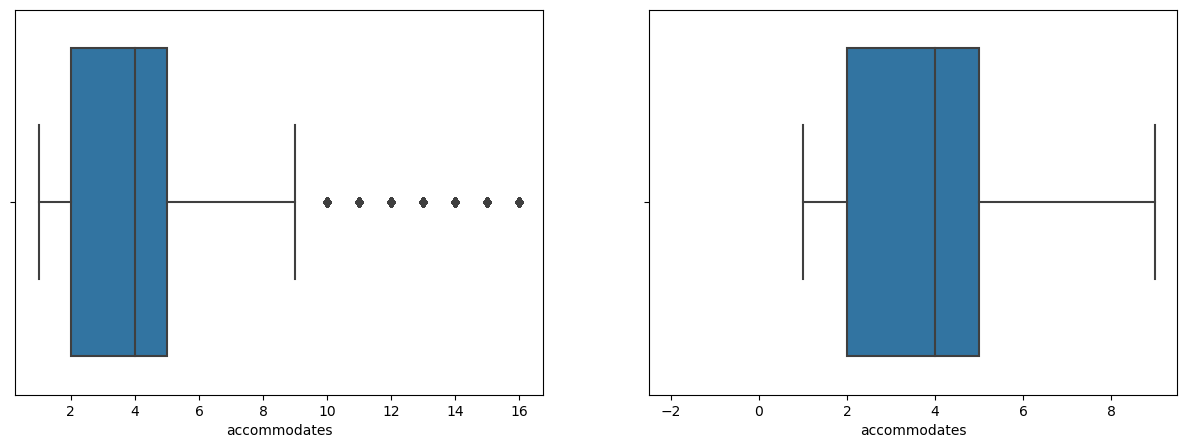

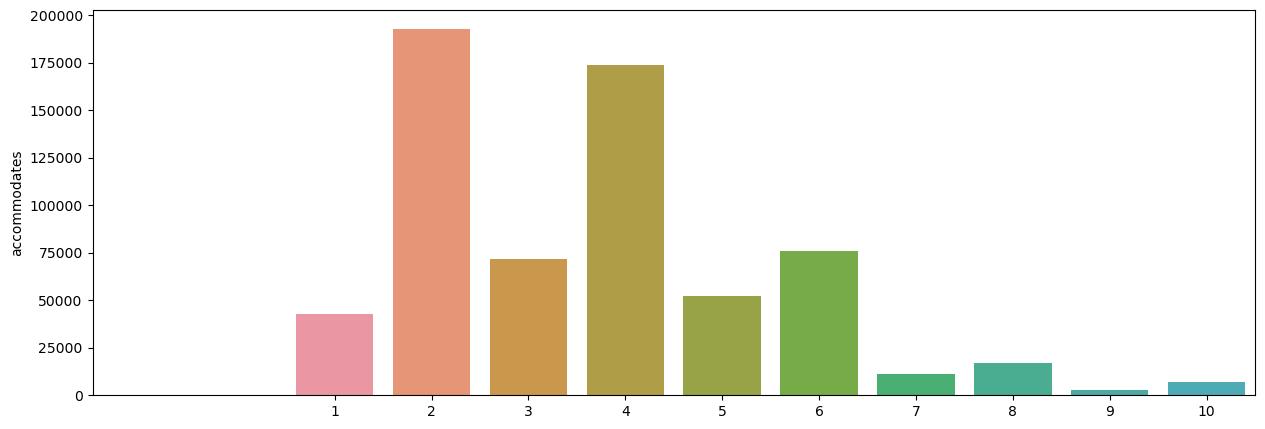

In [27]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas')

13146 linhas removidas


### bathrooms

<Axes: ylabel='bathrooms'>

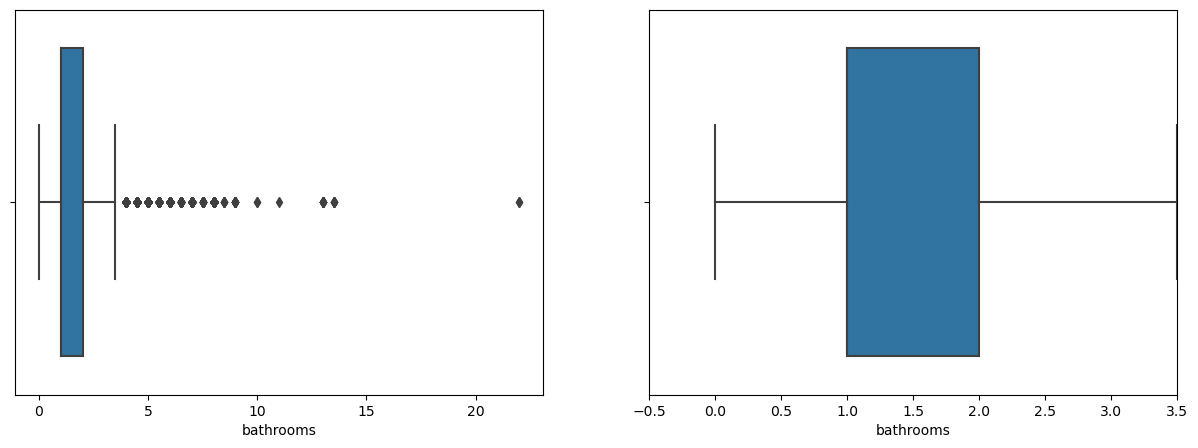

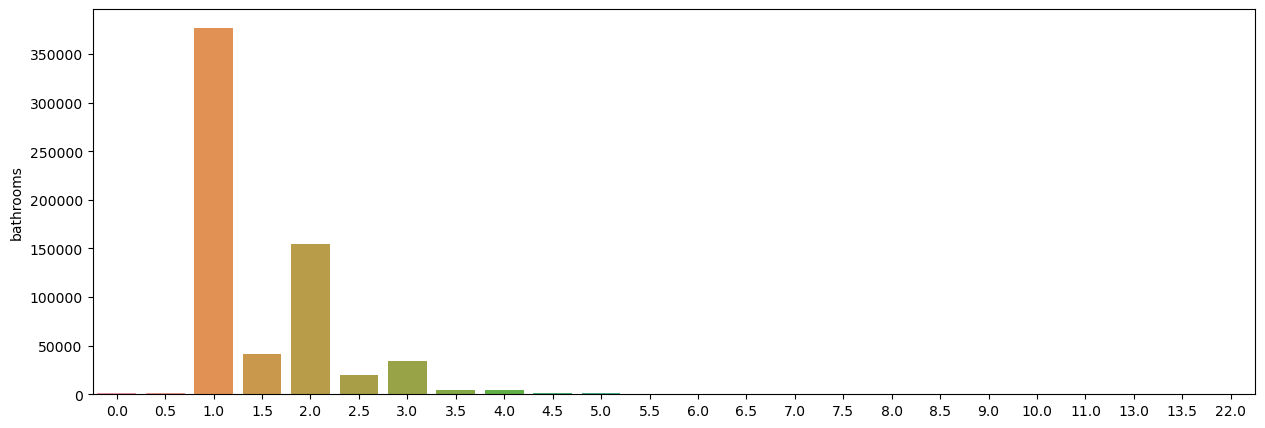

In [29]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x= base_airbnb['bathrooms'].value_counts().index, y= base_airbnb['bathrooms'].value_counts())

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas')

6894 linhas removidas


### bedrooms

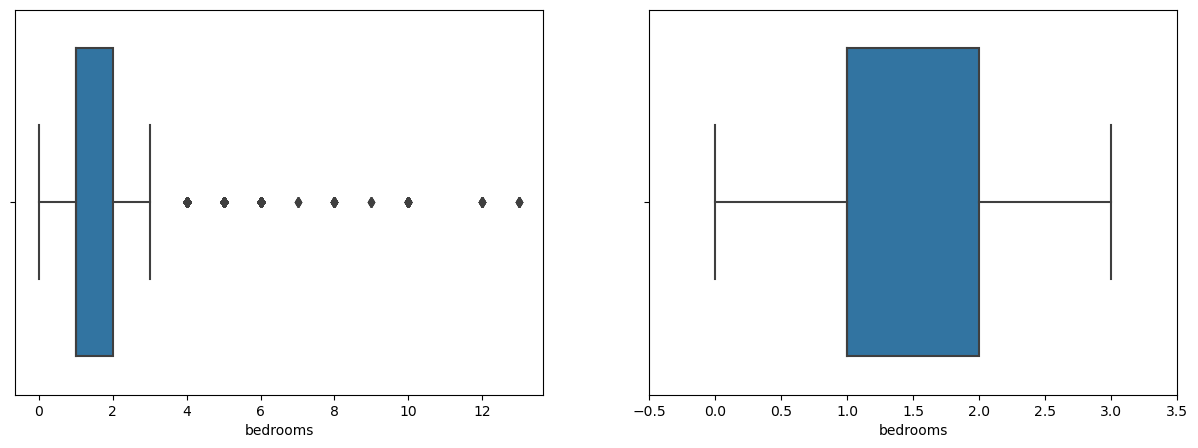

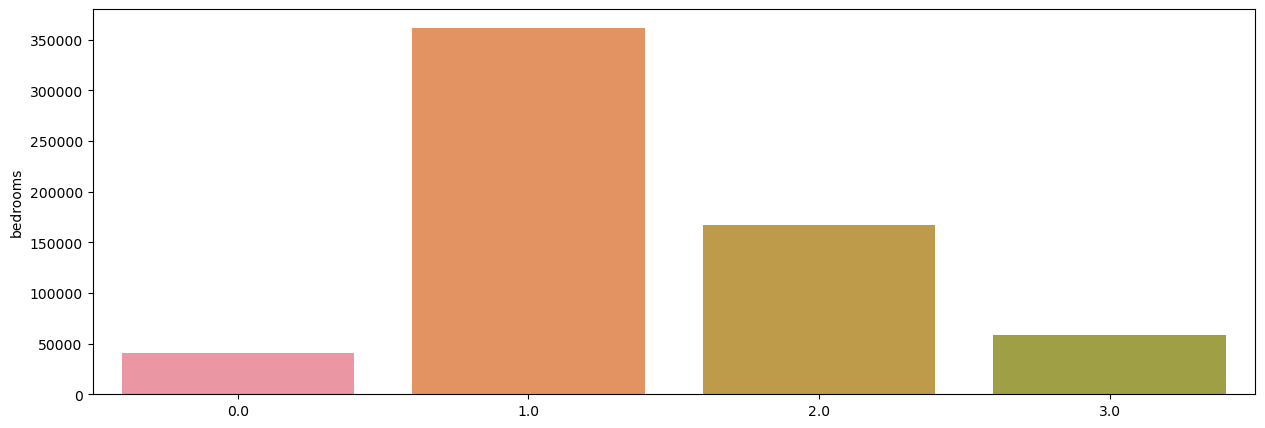

In [31]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} linhas removidas')

5482 linhas removidas


### beds

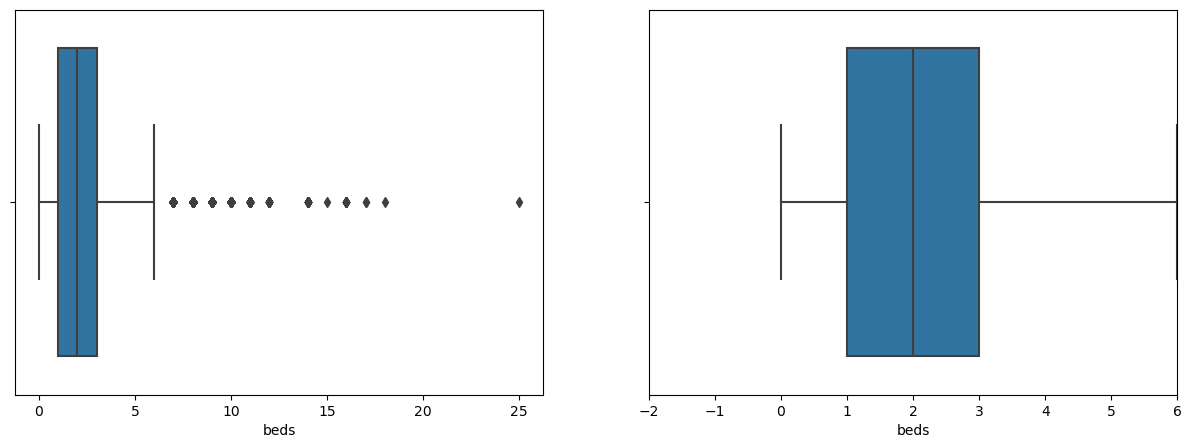

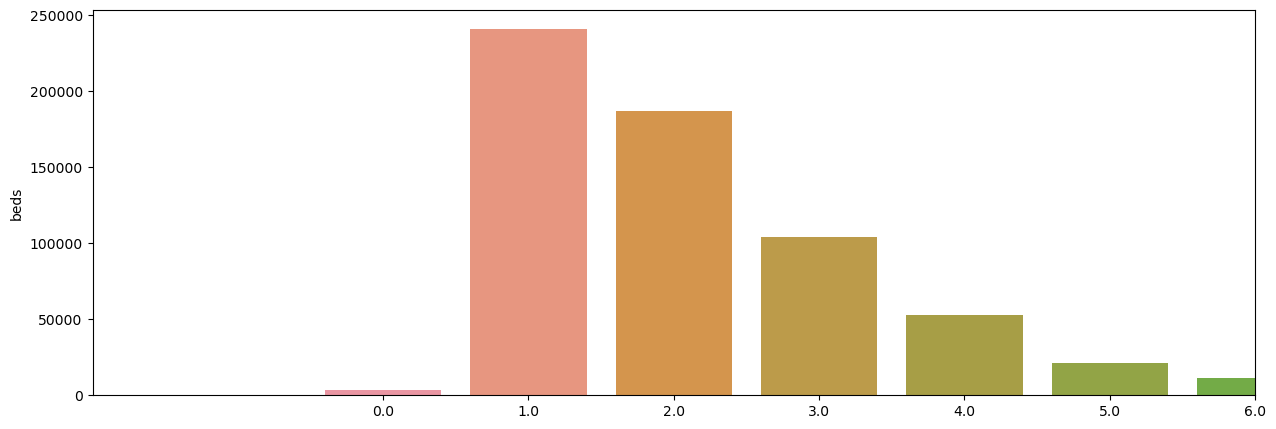

In [33]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [34]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} linhas removidas')

5622 linhas removidas


### guests_included

In [35]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included']))

(1.0, 1.0)


Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [36]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

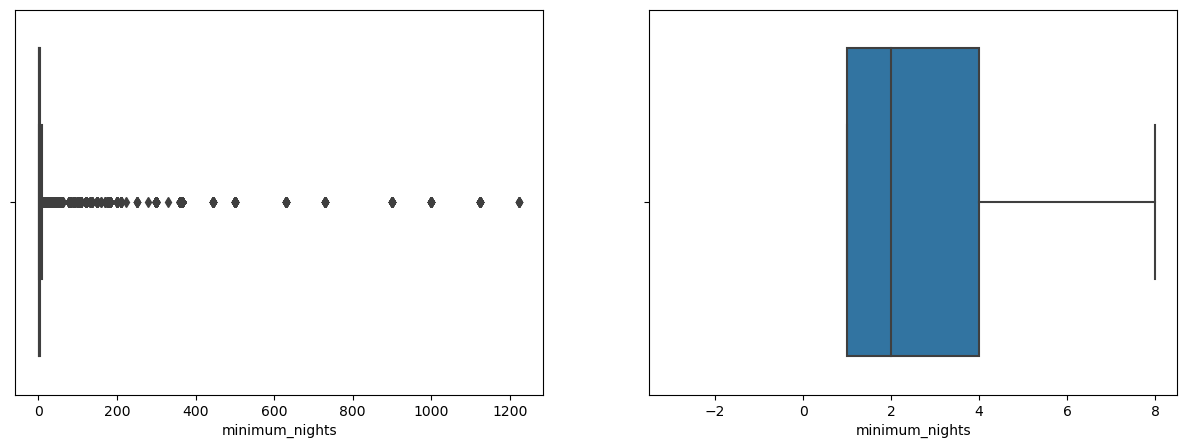

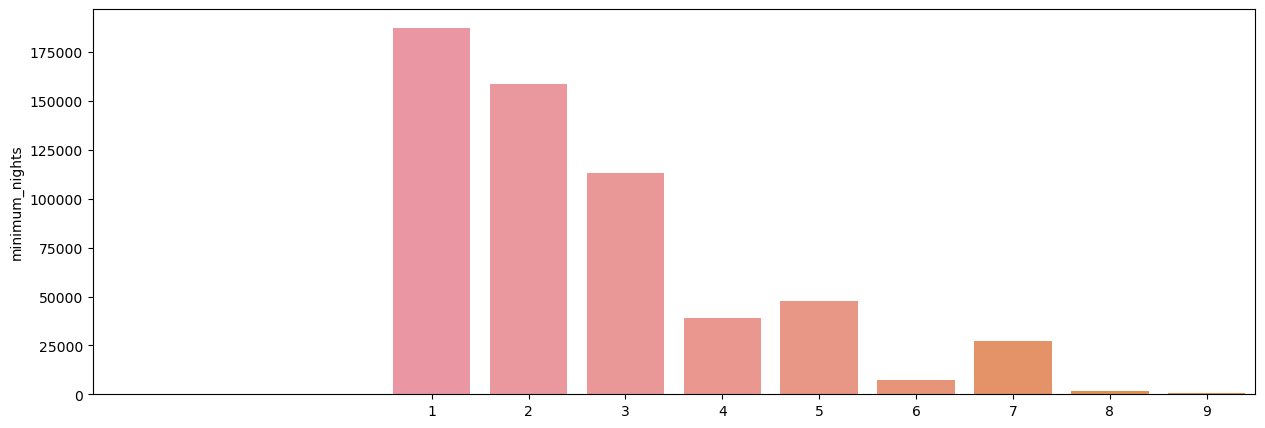

In [37]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [38]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas')

40383 linhas removidas


### maximum_nights

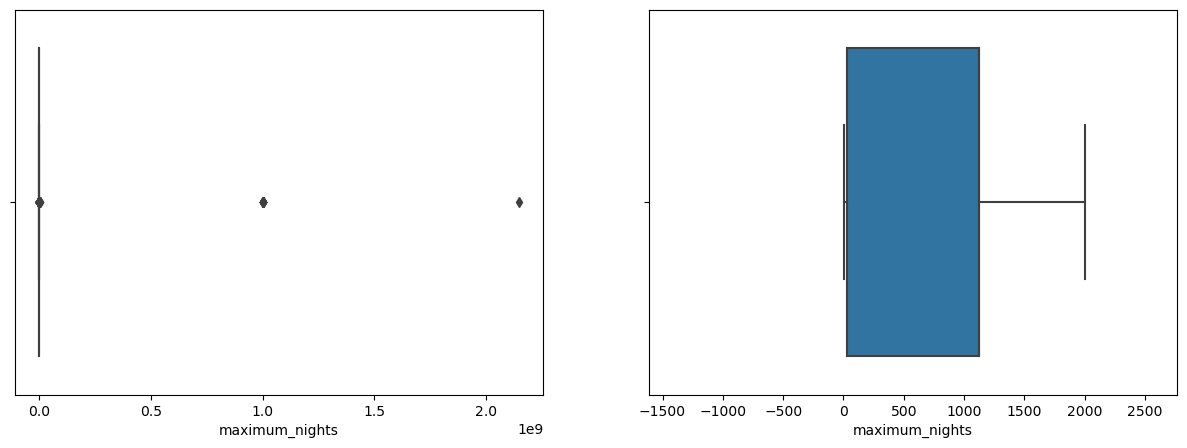

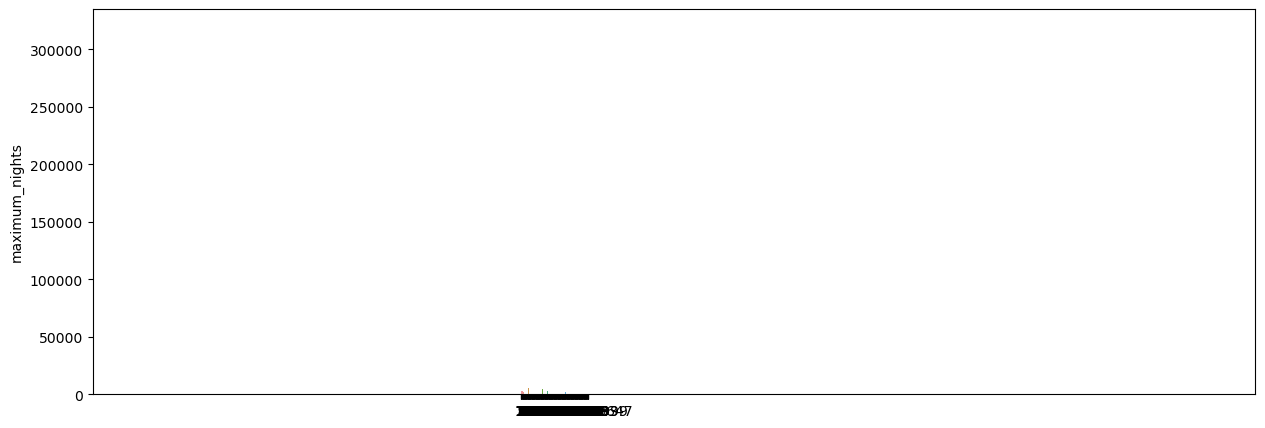

In [39]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [40]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

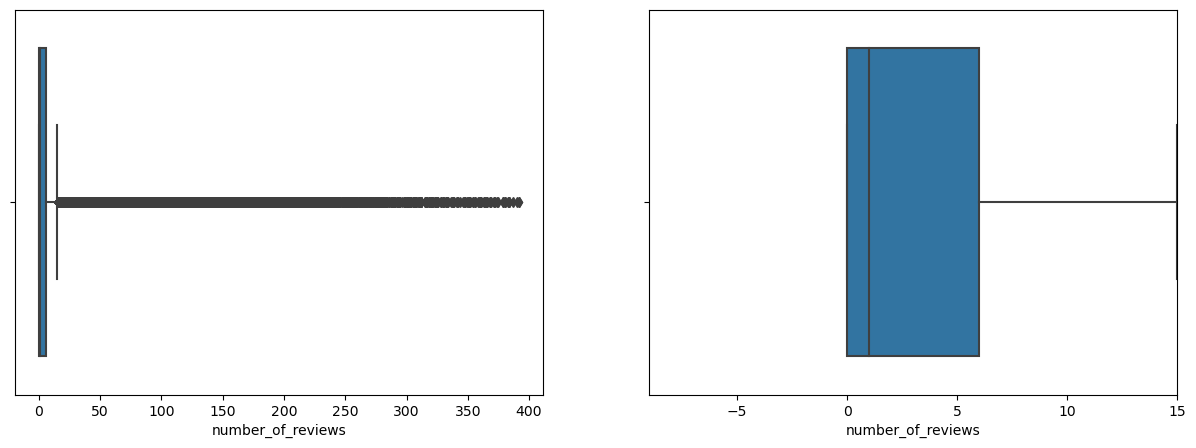

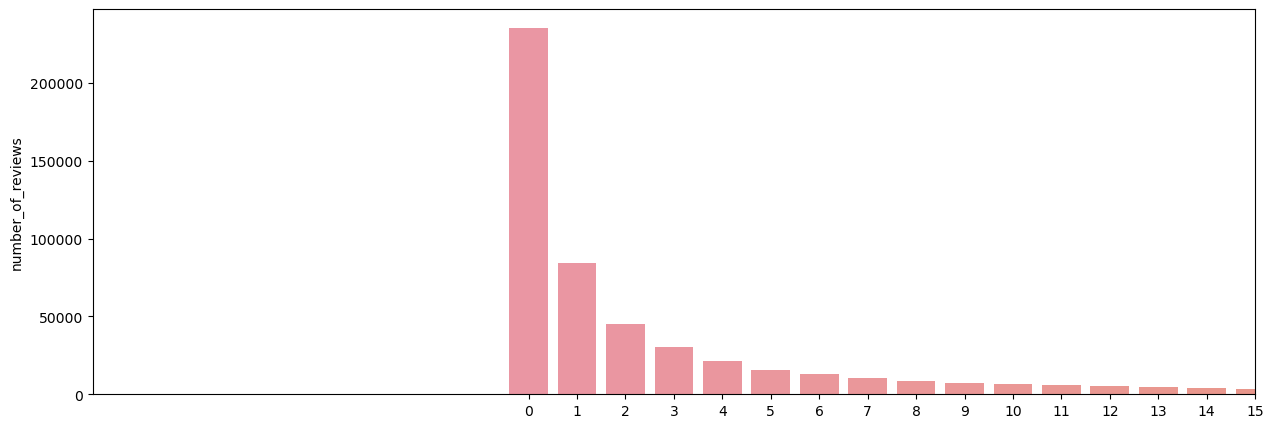

In [41]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [42]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

### property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

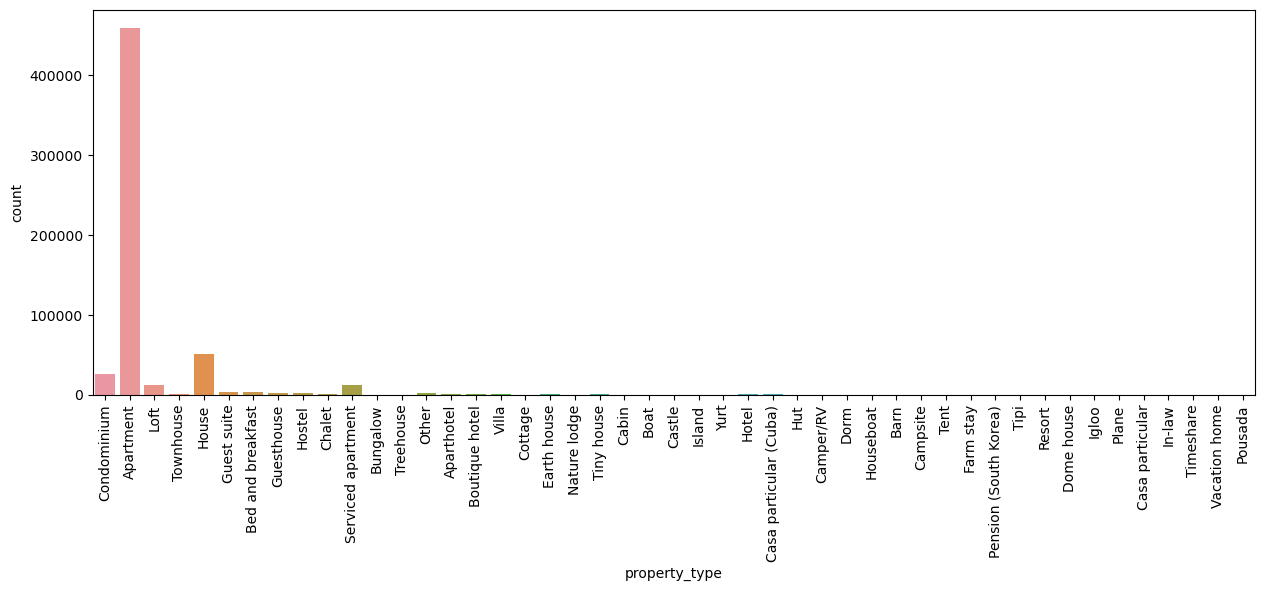

In [43]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x= 'property_type', data = base_airbnb)
grafico.tick_params(axis = 'x', rotation=90)

In [44]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


### room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


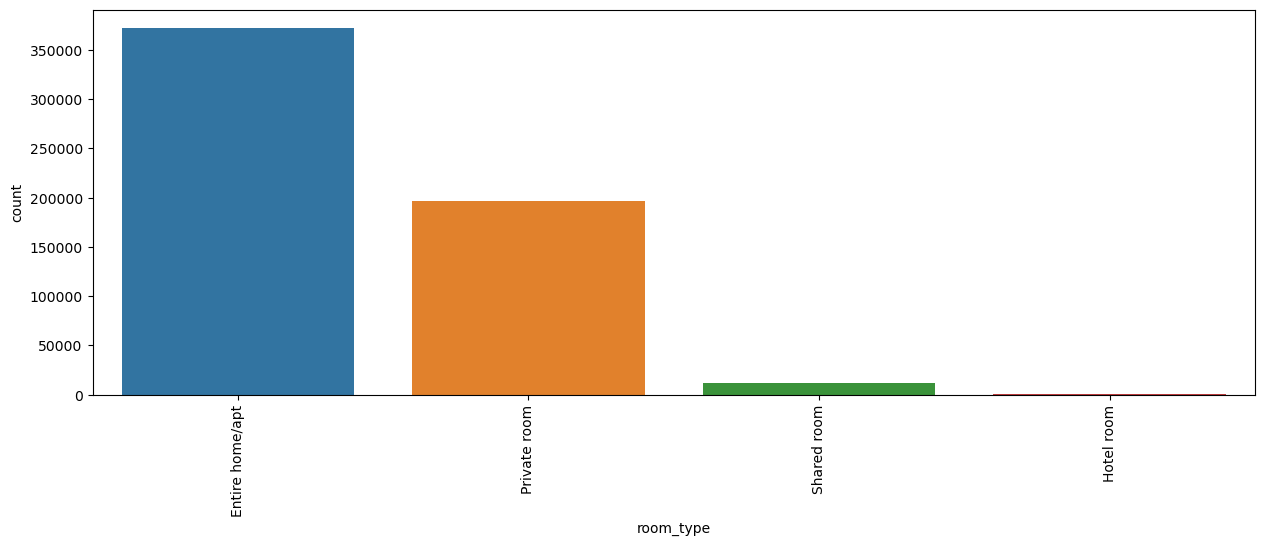

In [45]:
tabela_tipos_quarto = base_airbnb['room_type'].value_counts()
print(tabela_tipos_quarto)

plt.figure(figsize=(15,5))
grafico = sns.countplot(x= 'room_type', data = base_airbnb)
grafico.tick_params(axis = 'x', rotation=90)

### bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


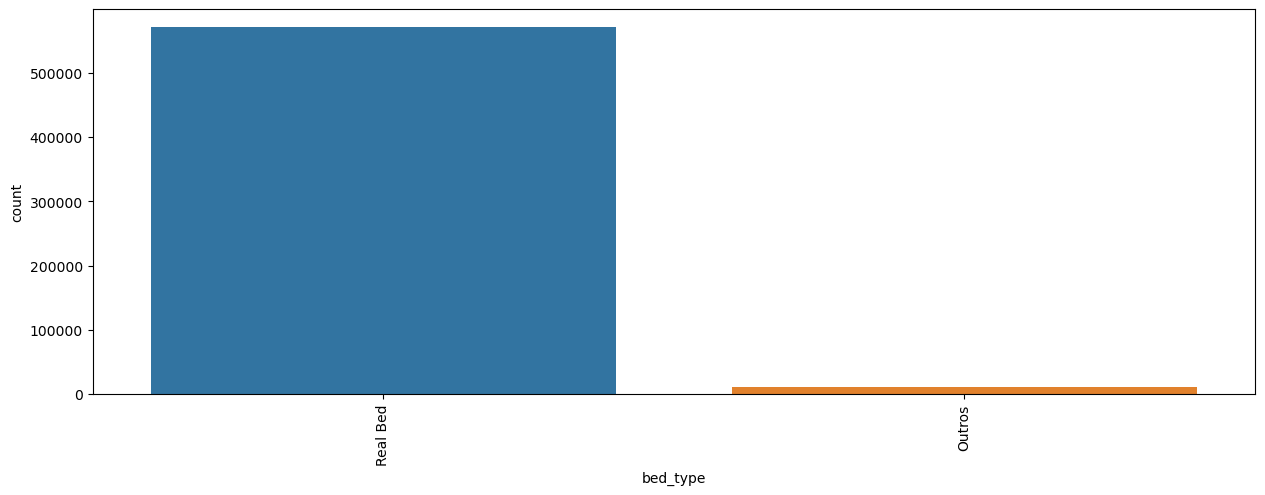

In [46]:
tabela_tipos_cama = base_airbnb['bed_type'].value_counts()
print(tabela_tipos_cama)

# agrupando categorias de bed_types
tabela_tipos_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_bed.index:
    if tabela_tipos_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x= 'bed_type', data = base_airbnb)
grafico.tick_params(axis = 'x', rotation=90)

### cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Strict                           9863
Name: cancellation_policy, dtype: int64


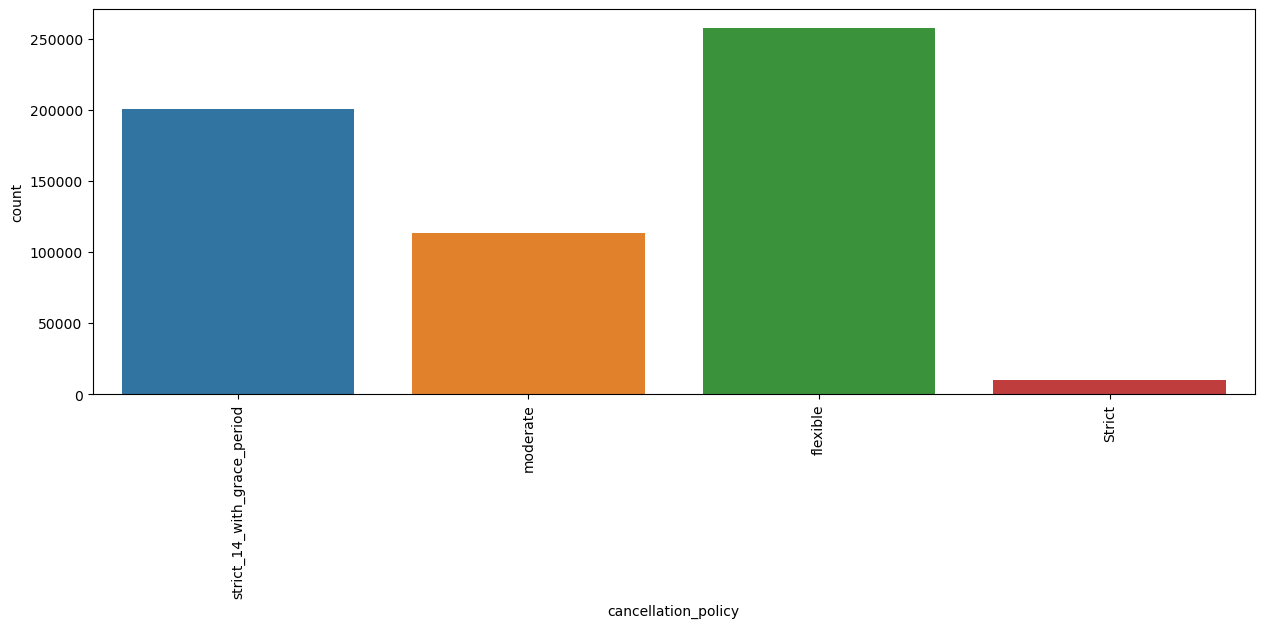

In [47]:
# tabela_tipos_cama = base_airbnb['cancellation_policy'].value_counts()
# print(tabela_tipos_cama)

# agrupando categorias de cancellation_policy
tabela_tipos_cancellation_policy = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_cancellation_policy.index:
    if tabela_tipos_cancellation_policy[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'Strict'

print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x= 'cancellation_policy', data = base_airbnb)
grafico.tick_params(axis = 'x', rotation=90)

### amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [48]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

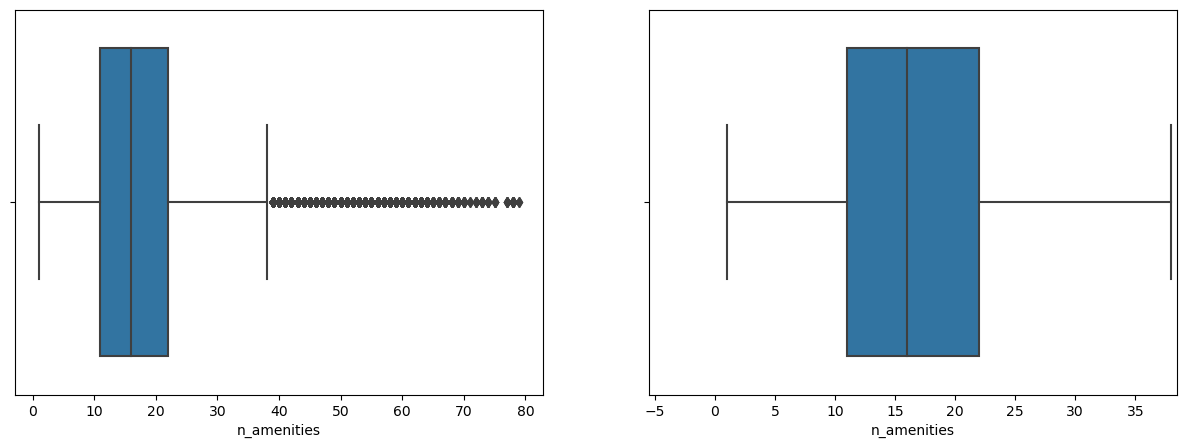

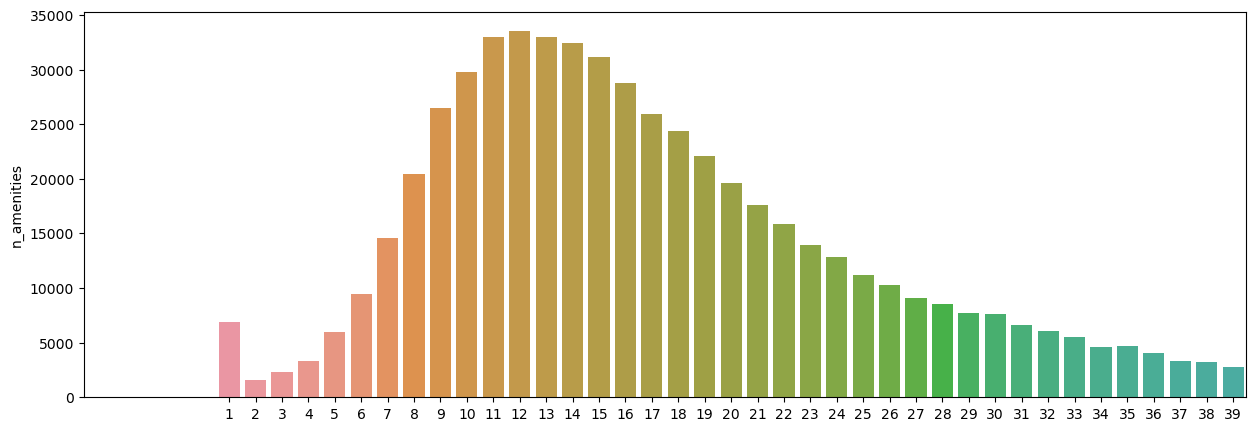

In [49]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [50]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'{linhas_removidas} linhas removidas')

24343 linhas removidas


### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço

In [51]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [52]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0
  

In [53]:
coluna_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data = base_airbnb_cod, columns = coluna_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count  latitude  longitude  accommodates  \
0                 1                  2.0 -22.96592  -43.17896             5   
1                 0                  0.0 -22.98467  -43.19611             6   
2                 0                  3.0 -22.97712  -43.19045             2   
3                 1                  1.0 -22.98302  -43.21427             3   
4                 0                  1.0 -22.98816  -43.19359             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
0        1.0       2.0   2.0  332.0          63.0  ...   
1        2.0       2.0   4.0  336.0           0.0  ...   
2        1.0       1.0   2.0  159.0          45.0  ...   
3        1.0       1.0   2.0  273.0          42.0  ...   
4        1.5       1.0   1.0  378.0          63.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
0                          1                    0                      0   
1                          1                    0                      0   
2                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
0                      0                0                  1   
1                      0                0                  1   
2                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   

   cancellation_policy_Strict  cancellation_policy_flexible  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             0   

   cancellation_policy_moderate  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   cancellation_policy_strict_14_with_grace_period  
0                                                1  
1                                                1  
2                                                1  
3                                                1  
4                                                1  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo 

-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. 

-> Quanto menor for o erro, melhor

In [67]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RMSE = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR2: {r2:.2%}\nRSME: {RMSE:.2f}'


- Escolha dos modelos a serem testados

    1. Random Forest
    2. Linear Regression
    3. Extra Tree

In [62]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'Random Forest': modelo_rf, 
           'Linear Regression': modelo_lr, 
           'Extra Tree': modelo_et 
          }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)



- Separa os dados em treino e teste + Treino o Modelo

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo Random Forest:
R2: 0.971396172403201
RSME: 44.79549974192775
Modelo Linear Regression:
R2: 0.3289030826868098
RSME: 216.977615438359
Modelo Extra Tree:
R2: 0.9732546814363215
RSME: 43.31578582401043


### Análise do Melhor Modelo

In [68]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo Random Forest:
R2: 97.14%
RSME: 44.80
Modelo Linear Regression:
R2: 32.89%
RSME: 216.98
Modelo Extra Tree:
R2: 97.33%
RSME: 43.32


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.

O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.

- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:

Modelo ExtraTrees:
R²: 97.33%
RSME: 43.32

### Ajustes e Melhorias no Melhor Modelo

0
host_is_superhost                                0.013396
host_listings_count                              0.039688
latitude                                         0.104532
longitude                                        0.101078
accommodates                                     0.072095
bathrooms                                        0.073786
bedrooms                                         0.103064
beds                                             0.052205
extra_people                                     0.086472
minimum_nights                                   0.065062
instant_bookable                                 0.022496
is_business_travel_ready                         0.000000
ano                                              0.011252
mes                                              0.004644
n_amenities                                      0.089292
property_type_Apartment                          0.012919
property_type_Bed and breakfast                  0.001298
property_type_Condominium                        0.005386
property_type_Guest suite                        0.000709
property_type_Guesthouse                         0.000926
property_type_Hostel                             0.000651
property_type_House                              0.007264
property_type_Loft                               0.002259
property_type_Outros                             0.002317
property_type_Serviced apartment                 0.002389
room_type_Entire home/apt                        0.073111
room_type_Hotel room                             0.000249
room_type_Private room                           0.003928
room_type_Shared room                            0.001825
bed_type_Outros                                  0.002682
bed_type_Real Bed                                0.002672
cancellation_policy_Strict                       0.000826
cancellation_policy_flexible                     0.019585
cancellation_policy_moderate                     0.012282
cancellation_policy_strict_14_with_grace_period  0.007658

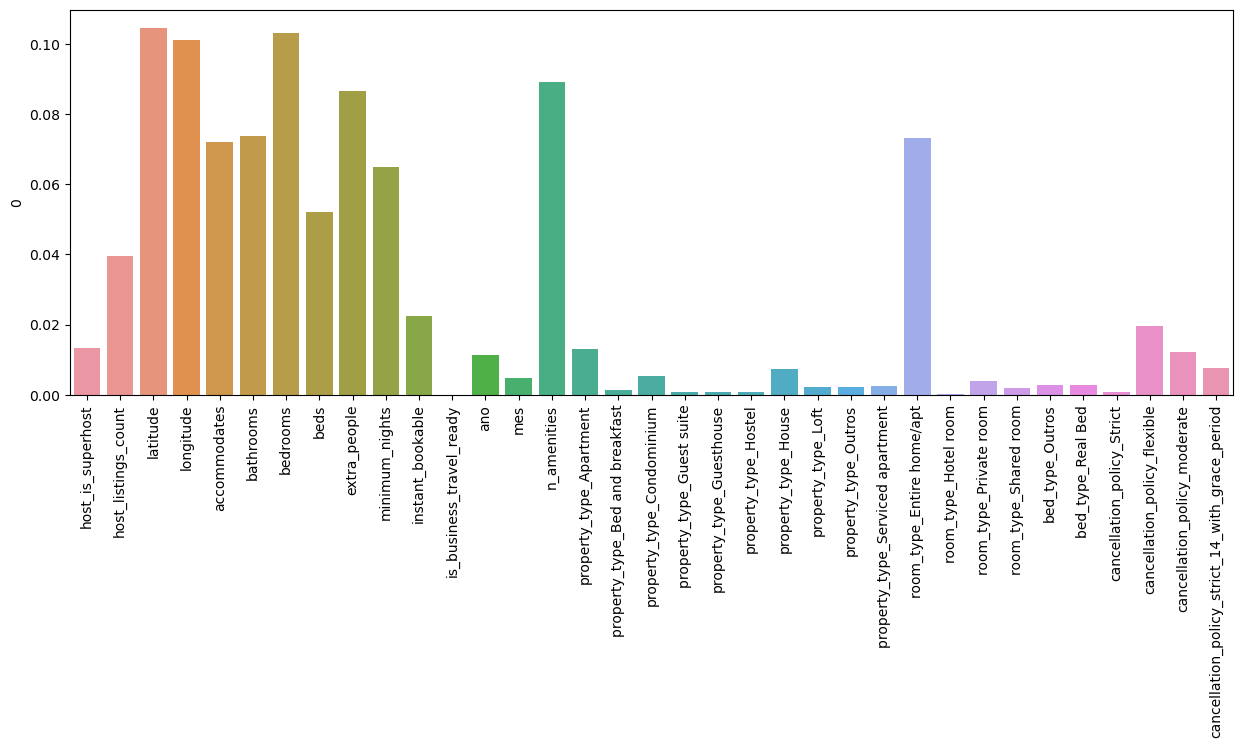

In [116]:
numeros = modelo_et.feature_importances_
nomes = x_train.columns

importancia_features = pd.DataFrame(numeros, nomes)
importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)


### Ajustes Finais no Modelo

In [117]:
base_airbnb_cod= base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))


Modelo ExtraTrees:
R2: 97.31%
RSME: 43.44


In [118]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_Strict', 'cancellation_policy_flexible',
       'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R2: 97.32%
RSME: 43.36


### Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)
- Passo 2 -> Escolher a forma de deploy:
Arquivo Executável + Tkinter
Deploy em Microsite (Flask)
Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [120]:
x['price'] = y
x.to_csv('dados.csv')

In [121]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']